In [6]:
import numpy as np
import pandas as pd
import itertools as it
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix,recall_score,accuracy_score
from sklearn.metrics import roc_curve, auc,precision_recall_curve, roc_curve
import matplotlib.pylab as plt
import matplotlib.patheffects as pe
import seaborn as sns
from tsne import *

import plotly.graph_objects as go

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
Data = pd.read_excel('Data.xlsx')
Data = Data.set_index('Date')
Y = Data['Class']
X = Data.drop('Class', axis = 1)

In [4]:
T = tsne(X = X, perplexity=60)
X = pd.DataFrame(T)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 4931...
Computing P-values for point 500 of 4931...
Computing P-values for point 1000 of 4931...
Computing P-values for point 1500 of 4931...
Computing P-values for point 2000 of 4931...
Computing P-values for point 2500 of 4931...
Computing P-values for point 3000 of 4931...
Computing P-values for point 3500 of 4931...
Computing P-values for point 4000 of 4931...
Computing P-values for point 4500 of 4931...
Mean value of sigma: 0.685436
Iteration 10: error is 22.648160
Iteration 20: error is 22.116846
Iteration 30: error is 18.794072
Iteration 40: error is 17.654123
Iteration 50: error is 17.248738
Iteration 60: error is 17.008929
Iteration 70: error is 16.899057
Iteration 80: error is 16.819025
Iteration 90: error is 16.711586
Iteration 100: error is 16.635254
Iteration 110: error is 2.414657
Iteration 120: error is 2.116111
Iteration 130: error is 1.939130
Iteration 140: error is 1.

(<Figure size 576x576 with 1 Axes>,
 [Text(0.9021196600860953, -3.2659595375571437, '-1'),
  Text(0.002005036011107239, 3.1775153822762308, '0'),
  Text(-0.04008335243662663, -3.514655767063019, '1')])

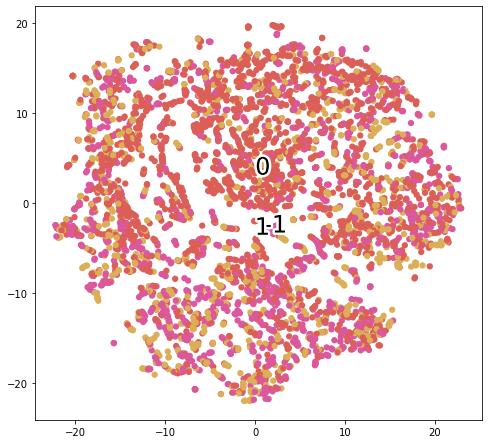

In [7]:
def plot(x, colors):
  
    palette = np.array(sns.color_palette("hls", 10))  #Choosing color palette 

    # Create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    # Add the labels for each digit.
    txts = []
    for i in range(-1,2,1):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    return f, ax, txts

plot(T, Y.values)

### Parameters

In [22]:
step = 100
ts_prop = 0.1
va_prop = 0.2

Hyper_Parameters = [['linear', 'poly', 'rbf', 'sigmoid']] # kernel
set_parameters = [i for i in it.product(*Hyper_Parameters)]

#### Error real y de entrenamiento deseados

In [23]:
Epsilon = 0.15
delta = 0.15

#### Garantia probable de aprendizaje ($\eta_{estimado}$) y Tamaño optimo de la muestra $\eta_{optimo}$

#### $\eta_{estimado}$

In [24]:
n_est = int(np.ceil((1/Epsilon)*(np.log(len(set_parameters)) + np.log(1/delta))))

#### $\eta_{optimo}$

In [25]:
n_opt = X.shape[1]+1

#### Division del conjunto: entrenamiento (70%), validacion (20%) y prueba (10%)

In [26]:
X1, X1_ts, Y1,Y1_ts = train_test_split(X, Y, train_size = 1-ts_prop, random_state=19)
X1_tr, X1_va, Y1_tr, Y1_va = train_test_split(X1, Y1, train_size = 1-va_prop, random_state=19)

#### Discretizacion para explorar el aumento de $\eta$

In [27]:
N = range(n_est, round(X1_tr.shape[0]*(1-va_prop)), step)

### Exploracion de modelos partiendo de $\eta_{estimado}$, es claro que $\eta_{estimado}$ es tenido en cuenta ya que $\eta_{estimado} < \eta_{optimo}$

In [28]:
n_est_mod_results = {
    'Model': [None for i in range(len(set_parameters))],
    'Accuracy': np.zeros((len(N),len(set_parameters))),
    'Precision': np.zeros((len(N),len(set_parameters))),
    'Recall': np.zeros((len(N),len(set_parameters)))
}

In [ ]:
for j in range(len(set_parameters)):
    svmc = SVC(kernel= set_parameters[j][0])
    for i in range(len(N)):
        np.random.seed(seed = 19)
        ind1 = np.random.randint(0, X1_tr.shape[0], N[i])
        svmc.fit(X1_tr.iloc[ind1,], Y1_tr[ind1])
        y_pred = svmc.predict(X1_va)
        n_est_mod_results['Accuracy'][i,j] = accuracy_score(Y1_va, y_pred)
        n_est_mod_results['Precision'][i,j] = precision_score(Y1_va, y_pred, average = 'macro')
        n_est_mod_results['Recall'][i,j] = recall_score(Y1_va, y_pred, average = 'macro')
    n_est_mod_results['Model'][j] = svmc
    
ind_bst = np.where(n_est_mod_results['Accuracy'] == np.amax(n_est_mod_results['Accuracy']))[1][0]
n_est_mod_results['Best'] = set_parameters[ind_bst]

#### Grid search

In [ ]:
Hyper_Parameters = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

clf = GridSearchCV(SVC(), Hyper_Parameters, cv = 5)
clf.fit(X1_tr.values, Y1_tr)
clf.best_params_

In [ ]:
fig1 = go.Figure(data=[go.Surface(z=n_est_mod_results['Accuracy'])])

fig1.update_layout(title='Accuracy Surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig1.show()

In [ ]:
fig2 = go.Figure(data=[go.Surface(z=n_est_mod_results['Precision'])])

fig2.update_layout(title='Precision', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig2.show()

In [ ]:
fig3 = go.Figure(data=[go.Surface(z=n_est_mod_results['Recall'])])

fig3.update_layout(title='Recall', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig3.show()